# Portfolio's Building #

### Rebalancing Weights ###

In [1]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Optimization
from scipy.optimize import minimize

# Visualization
import matplotlib.pyplot as plt

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from config import get_tickers
from data_downloader import get_market_data
from portfolios_toolkit import calculate_analytics
from portfolios_toolkit import markowitz_weights

In [2]:
tickers = get_tickers(mod="2.4")

tickers

['AAPL', 'AMZN', 'META', 'MSFT', 'NVDA']

In [3]:
# Import data
df_returns = pd.DataFrame()

for ticker in tickers:
    df = get_market_data(
        ticker=ticker, 
        start_date='2010-01-01', 
        end_date='2025-01-01', 
        returns=True
    )
    
    returns = df['returns'].rename(ticker)
    
    df_returns = pd.concat([df_returns, returns], axis=1)
    
    print(f'Data Ready for {ticker}')

df_returns.index.name = 'date'
df_returns.index = pd.to_datetime(df_returns.index)

Data Ready for AAPL
Data Ready for AMZN
Data Ready for META
Data Ready for MSFT
Data Ready for NVDA


In [4]:
df_returns

,AAPL,AMZN,META,MSFT,NVDA
date,,,,,
2010-01-05,0.001728,0.005883,NaN,0.000323,0.014497
2010-01-06,-0.016034,-0.018282,NaN,-0.006156,0.006376
2010-01-07,-0.001850,-0.017160,NaN,-0.010454,-0.019792
2010-01-08,0.006626,0.026717,NaN,0.006873,0.002159
2010-01-11,-0.008861,-0.024335,NaN,-0.012802,-0.014115
...,...,...,...,...,...
2024-12-24,0.011413,0.017573,0.013084,0.009330,0.003930
2024-12-26,0.003171,-0.008770,-0.007266,-0.002781,-0.002070
2024-12-27,-0.013331,-0.014641,-0.005884,-0.017453,-0.021088


In [5]:
df_returns.mean()

AAPL    0.000970
AMZN    0.000925
META    0.000861
MSFT    0.000767
NVDA    0.001526
dtype: float64

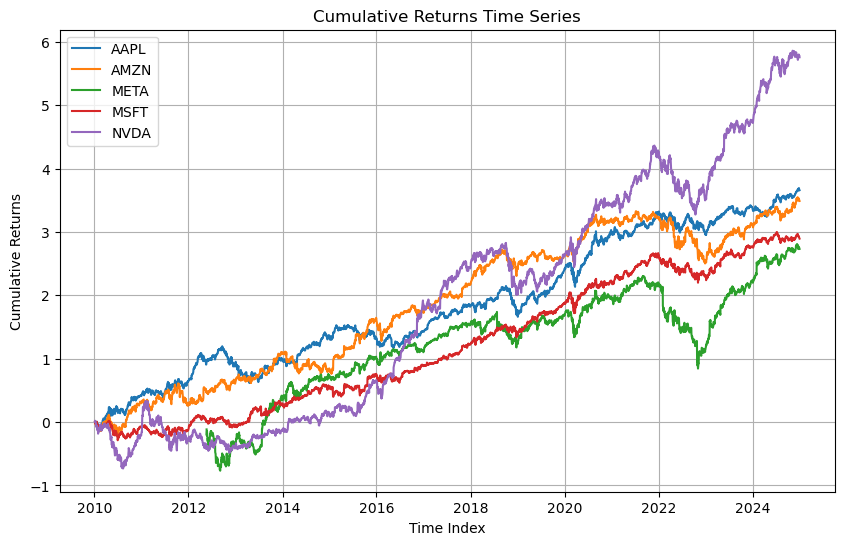

In [6]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(df_returns.cumsum(), label=df_returns.columns, alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time Index')
plt.ylabel('Cumulative Returns')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [7]:
# Let us Calculate the Weights
def rolling_weights(
    returns, 
    desired_returns, 
    window=252, 
    rebalance_freq=126
):

    # Lists to Store Things
    weights_list = []
    dates = []

    for i in range(window, len(returns), rebalance_freq):
        past_returns = returns.iloc[i - window:i]  # Rolling Window
        past_excepted_returns = past_returns.mean()
        past_cov_matrix = past_returns.cov()

        # Calculate Weights
        w = markowitz_weights(past_excepted_returns, past_cov_matrix, desired_returns)

        # Save weights and dates
        weights_list.append(w)
        dates.append(returns.index[i])

    # Create the DataFrame
    weights_df = pd.DataFrame(weights_list, index=dates, columns=returns.columns)

    # Expand the DataFrame
    weights_df = weights_df.reindex(returns.index, method='ffill')

    return weights_df.dropna()

In [8]:
# Create the DataFrames of Returns
df_weights = rolling_weights(df_returns, 0.001)

df_weights

,AAPL,AMZN,META,MSFT,NVDA
date,,,,,
2012-07-05,0.386599,0.041857,0.068608,0.670811,-0.167876
2012-07-06,0.386599,0.041857,0.068608,0.670811,-0.167876
2012-07-09,0.386599,0.041857,0.068608,0.670811,-0.167876
2012-07-10,0.386599,0.041857,0.068608,0.670811,-0.167876
2012-07-11,0.386599,0.041857,0.068608,0.670811,-0.167876
...,...,...,...,...,...
2024-12-24,0.398832,0.155424,-0.030057,0.501208,-0.025408
2024-12-26,0.398832,0.155424,-0.030057,0.501208,-0.025408
2024-12-27,0.398832,0.155424,-0.030057,0.501208,-0.025408


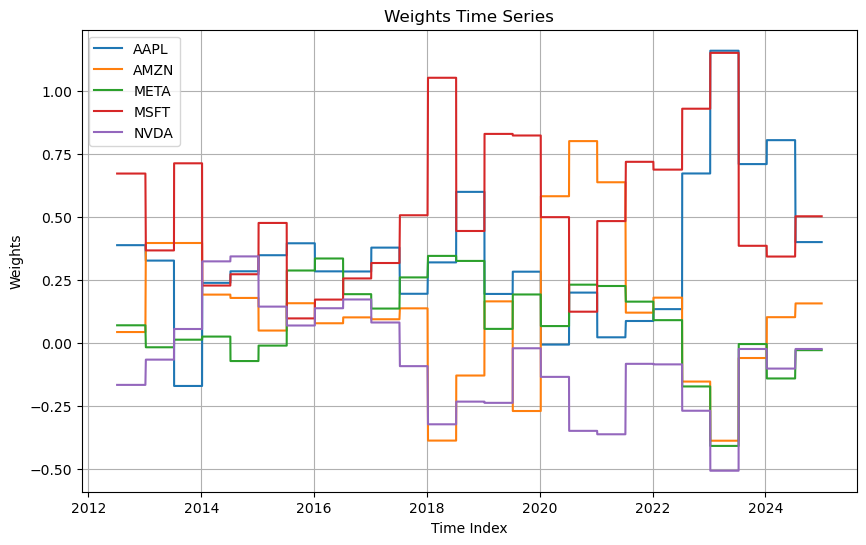

In [9]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(df_weights, label=df_weights.columns, alpha=1)
# Config
plt.title('Weights Time Series')
plt.xlabel('Time Index')
plt.ylabel('Weights')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [10]:
# Common Index
common_index = df_returns.index.intersection(df_weights.index)  # Fechas en común
df_returns_reindex = df_returns.reindex(common_index)
df_weights = df_weights.reindex(common_index)

df_returns_reindex

,AAPL,AMZN,META,MSFT,NVDA
date,,,,,
2012-07-05,0.017415,-0.010819,0.008617,-0.001953,-0.010196
2012-07-06,-0.006679,-0.008892,0.008228,-0.016752,-0.019217
2012-07-09,0.013134,0.000000,0.013772,-0.006313,-0.013524
2012-07-10,-0.009296,-0.024970,-0.022000,-0.008704,-0.030724
2012-07-11,-0.006234,-0.005161,-0.016016,-0.014906,-0.016517
...,...,...,...,...,...
2024-12-24,0.011413,0.017573,0.013084,0.009330,0.003930
2024-12-26,0.003171,-0.008770,-0.007266,-0.002781,-0.002070
2024-12-27,-0.013331,-0.014641,-0.005884,-0.017453,-0.021088


In [11]:
# Create the Portfolio Returns
df_weighted_returns = df_returns_reindex * df_weights

df_weighted_returns

,AAPL,AMZN,META,MSFT,NVDA
date,,,,,
2012-07-05,0.006733,-0.000453,0.000591,-0.001310,0.001712
2012-07-06,-0.002582,-0.000372,0.000564,-0.011237,0.003226
2012-07-09,0.005078,0.000000,0.000945,-0.004235,0.002270
2012-07-10,-0.003594,-0.001045,-0.001509,-0.005839,0.005158
2012-07-11,-0.002410,-0.000216,-0.001099,-0.009999,0.002773
...,...,...,...,...,...
2024-12-24,0.004552,0.002731,-0.000393,0.004676,-0.000100
2024-12-26,0.001265,-0.001363,0.000218,-0.001394,0.000053
2024-12-27,-0.005317,-0.002276,0.000177,-0.008748,0.000536


In [12]:
# Create the Portfolio Returns
df_returns_portfolio = df_returns.copy()

# Add the columns
df_returns_portfolio['Portfolio'] =  df_weighted_returns.sum(axis = 1)

df_returns_portfolio['Portfolio'].dropna()

date
2012-07-05    0.007273
2012-07-06   -0.010401
2012-07-09    0.004058
2012-07-10   -0.006829
2012-07-11   -0.010951
                ...   
2024-12-24    0.011466
2024-12-26   -0.001221
2024-12-27   -0.015627
2024-12-30   -0.013373
2024-12-31   -0.007225
Name: Portfolio, Length: 3143, dtype: float64

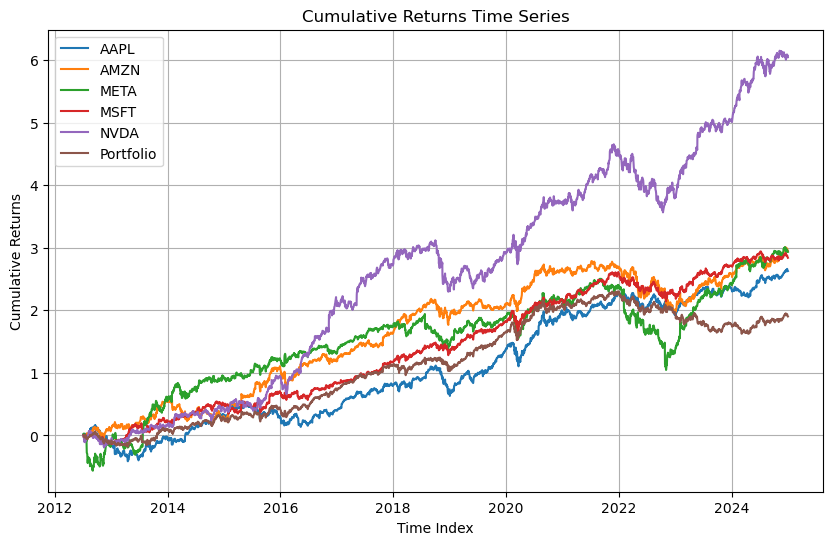

In [13]:
# Time Series Graphs

df_plot = df_returns_portfolio.dropna()

plt.figure(figsize=(10, 6))
plt.plot(df_plot.cumsum(), label=df_plot.columns, alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time Index')
plt.ylabel('Cumulative Returns')
plt.legend()

# Show
plt.grid(True)
plt.show()

### Define different rebalancing frequencies ###

In [14]:
# Desired Return
dr = 0.001

In [15]:
# Create weights for different rebalancing frequencies
df_weights_5d = rolling_weights(df_returns, dr, rebalance_freq=5)
df_weights_21d = rolling_weights(df_returns, dr, rebalance_freq=21)
df_weights_63d = rolling_weights(df_returns, dr, rebalance_freq=63)
df_weights_126d = rolling_weights(df_returns, dr, rebalance_freq=126)
df_weights_252d = rolling_weights(df_returns, dr, rebalance_freq=252)

In [16]:
# Create the Returns
df_weighted_returns_5d = df_returns * df_weights_5d
df_weighted_returns_21d = df_returns * df_weights_21d
df_weighted_returns_63d = df_returns * df_weights_63d
df_weighted_returns_126d = df_returns * df_weights_126d
df_weighted_returns_252d = df_returns * df_weights_252d

In [17]:
# Add the columns
portfolios_df = pd.DataFrame(index = df_returns.loc['2016':].index)

portfolios_df['5d_port'] = df_weighted_returns_5d.sum(axis = 1)
portfolios_df['21d_port'] = df_weighted_returns_21d.sum(axis = 1)
portfolios_df['63d_port'] = df_weighted_returns_63d.sum(axis = 1)
portfolios_df['126d_port'] = df_weighted_returns_126d.sum(axis = 1)
portfolios_df['252d_port'] = df_weighted_returns_252d.sum(axis = 1)

portfolios_df

,5d_port,21d_port,63d_port,126d_port,252d_port
date,,,,,
2016-01-04,-0.016586,-0.014834,-0.022336,-0.018075,-0.010685
2016-01-05,-0.003105,-0.003799,-0.002680,-0.007848,-0.004664
2016-01-06,-0.013867,-0.014055,-0.014777,-0.012023,-0.021698
2016-01-07,-0.043580,-0.043580,-0.043580,-0.043580,-0.043580
2016-01-08,-0.003073,-0.003073,-0.003073,-0.003073,-0.003073
...,...,...,...,...,...
2024-12-24,0.010927,0.011136,0.010834,0.011466,0.011857
2024-12-26,-0.000921,-0.001205,-0.001173,-0.001221,0.001962
2024-12-27,-0.015057,-0.014913,-0.015348,-0.015627,-0.015130


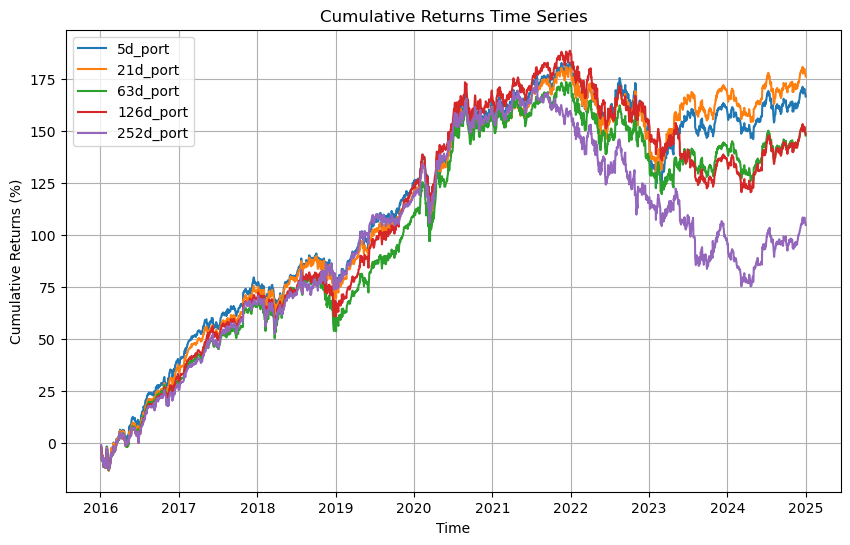

In [18]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(portfolios_df.cumsum().mul(100), label=portfolios_df.columns, alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns (%)')
plt.legend()

# Show
plt.grid(True)
plt.show()

### Comparing Portfolios ###

In [19]:
# Now the table
analytics_table = calculate_analytics(portfolios_df)

analytics_table

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
5d_port,18.519115,25.784410,0.718229,-0.488691,-2.625604
21d_port,19.587800,25.529292,0.767268,-0.431508,-2.533011
63d_port,16.434618,25.664775,0.640357,-0.455065,-2.654567
126d_port,16.491499,26.004332,0.634183,-0.541407,-2.630858
252d_port,11.657311,26.582905,0.438527,-0.672826,-2.756499


### Constraining Weights ###

The problem is that we cannot create large portfolios (with many components) using this methodology because, sometimes, many assets will have high levels of leverage. Therefore, we can use other methods:

In [20]:
# Adding weights restrictions:
def markowitz_scipy(
    expected_returns,
    cov_matrix,
    target_return,
    max_weight=0.1
):
    # Number of observations
    n = len(expected_returns)
    
    # Objective Function: Variance
    def objective(w):
        return w.T @ cov_matrix @ w
    
    # Constraints:
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},                         # Weights must sum 1
        {'type': 'eq', 'fun': lambda w: expected_returns @ w - target_return}   # Objective Returns
    ]
    
    # Set limits for weights
    bounds = [(-max_weight, max_weight) for _ in range(n)]
    
    # Initial weights (equal weighted)
    w0 = np.ones(n) / n
    
    # Optimization (Minimize Variance)
    result = minimize(
        objective, 
        w0, 
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints
    )
    
    if result.success:
        return result.x
    else:
        raise ValueError("La optimización falló: " + result.message)

In [21]:
# Import Data
df_returns_big = pd.read_csv(r'..\additional_data\stocks_returns.csv')
df_returns_big = df_returns_big.rename(columns={'Unnamed: 0':'Date'})
df_returns_big.set_index('Date', inplace=True)
df_returns_big.index = pd.to_datetime(df_returns_big.index)
df_returns_big = df_returns_big.dropna(axis=1)

df_returns_big

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.018915,-0.028576,-0.018998,0.000222,-0.004989,-0.018352,-0.035215,-0.000721,-0.014722,-0.010052,...,-0.013900,0.000000,-0.017166,-0.011416,-0.027743,-0.064259,-0.020527,0.036625,-0.014177,-0.006022
2015-01-06,-0.015700,0.000094,-0.004962,-0.011421,-0.020350,-0.023753,-0.019911,-0.008324,-0.019973,-0.011709,...,-0.017255,-0.001108,-0.021562,0.005306,-0.005330,-0.005898,-0.012351,-0.008513,-0.007231,-0.009804
2015-01-07,0.013184,0.013925,0.039621,0.008076,0.008190,0.010462,0.014920,0.008685,-0.002089,0.007747,...,0.016088,0.003045,0.028945,0.008598,0.010081,0.007857,0.032601,0.024566,0.025146,0.020432
2015-01-08,0.029534,0.037702,0.010404,0.020345,0.025135,0.017501,-0.014717,0.022681,0.024446,0.003522,...,0.019467,0.010722,0.011959,0.011532,0.016508,0.007517,0.017270,0.010561,0.021134,0.015282
2015-01-09,-0.007364,0.001072,-0.027736,-0.010563,-0.014922,-0.000731,-0.008566,-0.007188,-0.009054,-0.011270,...,-0.011519,-0.001368,0.012422,-0.012361,-0.001411,-0.019043,-0.001768,-0.014529,0.014508,0.001583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.011083,0.011413,0.008985,0.003929,0.002683,0.014782,0.004355,0.007822,0.012494,0.013291,...,0.009663,0.006390,0.007575,0.007210,0.000940,0.005432,0.008480,0.004484,0.012187,0.002553
2024-12-26,-0.001986,0.003171,-0.004454,0.004434,0.004944,-0.000138,-0.000395,0.002594,-0.003159,-0.002203,...,0.001981,-0.003190,0.005952,-0.000440,0.000845,0.002705,0.007380,-0.000466,0.003559,0.004966
2024-12-27,-0.002137,-0.013331,-0.006663,-0.002432,-0.008208,-0.004919,-0.000593,-0.003539,-0.008999,-0.006305,...,-0.000630,-0.006410,-0.007079,-0.000587,-0.000094,-0.007966,-0.005678,-0.003549,-0.019799,-0.005574


In [22]:
# Components:
expected_returns = df_returns_big.loc['2015'].mean()
covariance_matrix = df_returns_big.loc['2015'].cov()

In [31]:
unrestricted_weights = markowitz_weights(expected_returns, covariance_matrix, 0.0005)
unrestricted_weights = pd.Series(unrestricted_weights, index = df_returns_big.columns)
unrestricted_weights.name = 'weights'

unrestricted_weights

A      -0.432576
AAPL   -0.186221
ABBV    0.391854
ABT     0.214547
ADBE    1.548618
          ...   
XYL    -0.215766
YUM    -0.320099
ZBH     0.530273
ZBRA   -0.008499
ZTS    -0.895193
Name: weights, Length: 391, dtype: float64

In [32]:
restricted_weights = markowitz_scipy(expected_returns, covariance_matrix, 0.0005)
restricted_weights = pd.Series(restricted_weights, index = df_returns_big.columns)
restricted_weights.name = 'weights'

restricted_weights

A       0.002598
AAPL    0.002350
ABBV    0.002119
ABT     0.002520
ADBE    0.003586
          ...   
XYL     0.002340
YUM     0.002590
ZBH     0.002116
ZBRA    0.001921
ZTS     0.002927
Name: weights, Length: 391, dtype: float64

In [33]:
unrestricted_portfolio = df_returns_big.loc['2016':] @ unrestricted_weights
unrestricted_portfolio.name = 'unrestricted_portfolio'

unrestricted_portfolio

Date
2016-01-04   -0.002176
2016-01-05    0.066437
2016-01-06   -0.143840
2016-01-07   -0.219570
2016-01-08    0.000035
                ...   
2024-12-24   -0.007051
2024-12-26   -0.086879
2024-12-27   -0.005976
2024-12-30    0.036239
2024-12-31    0.043273
Name: unrestricted_portfolio, Length: 2264, dtype: float64

In [34]:
restricted_portfolio = df_returns_big.loc['2016':] @ restricted_weights
restricted_portfolio.name = 'restricted_portfolio'

restricted_portfolio

Date
2016-01-04   -0.017659
2016-01-05    0.003681
2016-01-06   -0.011647
2016-01-07   -0.022928
2016-01-08   -0.011658
                ...   
2024-12-24    0.007599
2024-12-26    0.001357
2024-12-27   -0.006934
2024-12-30   -0.010205
2024-12-31    0.001691
Name: restricted_portfolio, Length: 2264, dtype: float64

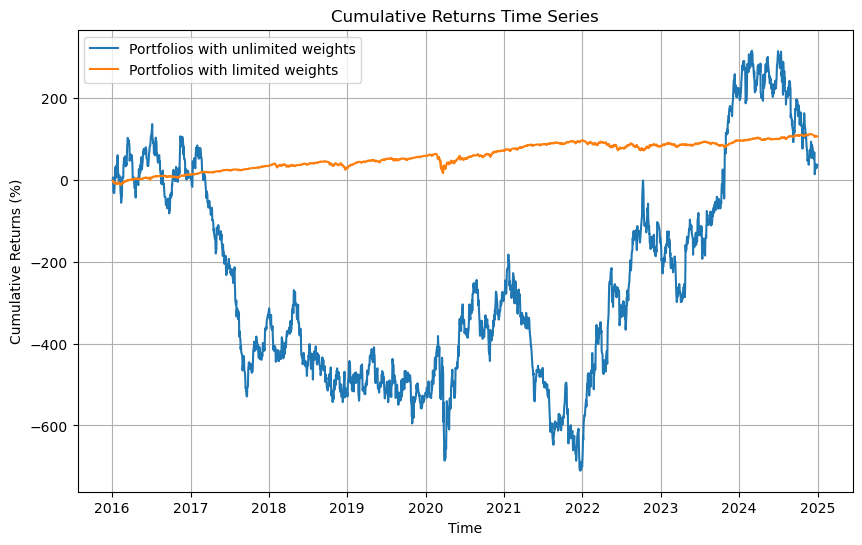

In [35]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(unrestricted_portfolio.cumsum().mul(100), label='Portfolios with unlimited weights', alpha=1)
plt.plot(restricted_portfolio.cumsum().mul(100), label='Portfolios with limited weights', alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns (%)')
plt.legend()

# Show
plt.grid(True)
plt.show()

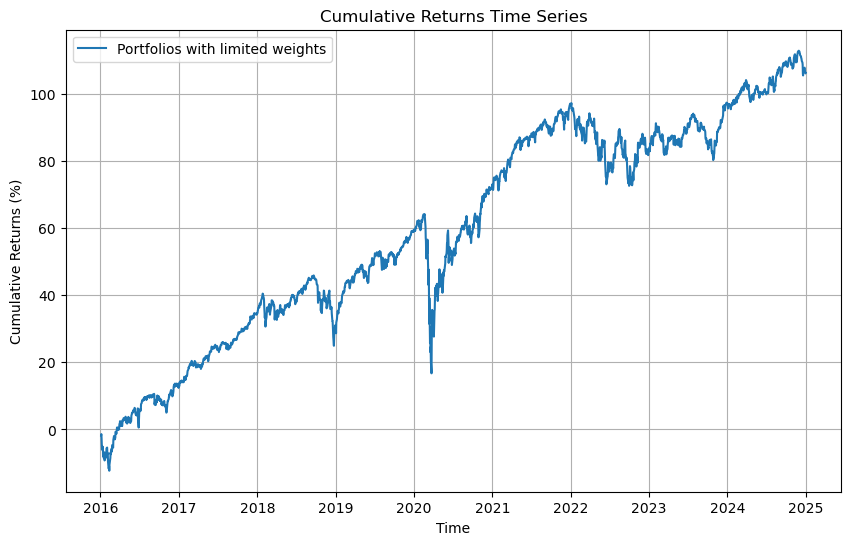

In [36]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(restricted_portfolio.cumsum().mul(100), label='Portfolios with limited weights', alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns (%)')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [37]:
# Create the analystics
limit_portfolios = pd.DataFrame(index=restricted_portfolio.index)

limit_portfolios['unrestricted_portfolio'] = unrestricted_portfolio
limit_portfolios['restricted_portfolio'] = restricted_portfolio

limit_portfolios

,unrestricted_portfolio,restricted_portfolio
Date,,
2016-01-04,-0.002176,-0.017659
2016-01-05,0.066437,0.003681
2016-01-06,-0.143840,-0.011647
2016-01-07,-0.219570,-0.022928
2016-01-08,0.000035,-0.011658
...,...,...
2024-12-24,-0.007051,0.007599
2024-12-26,-0.086879,0.001357
2024-12-27,-0.005976,-0.006934


In [38]:
calculate_analytics(limit_portfolios)

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
unrestricted_portfolio,4.129827,265.673955,0.015545,-1.000000,-26.784567
restricted_portfolio,11.817444,18.028029,0.655504,-0.399062,-1.622124
